# Compas Analysis

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.

## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.

In [159]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
raw_data = pd.read_csv('CompasAnalysis/compas-scores-two-years.csv')

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:
* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
* We coded the recidivist flag -- `is_recid` -- to be -1 if we could not find a compas case at all.
* In a similar vein, ordinary traffic offenses -- those with a `c_charge_degree` of 'O' -- will not result in Jail time are removed (only two of them).
* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

In [7]:
df = raw_data[['age','c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count','days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df = df[df['days_b_screening_arrest'] <= 30]
df = df[df['days_b_screening_arrest'] >= -30]
df = df[df['is_recid'] != -1]
df = df[df['c_charge_degree'] != '0']
df = df[df['score_text'] != 'N/A']
assert len(df) == 6172

Higher COMPAS scores are slightly correlated with a longer length of stay. 

In [9]:
df['length_of_stay'] = (pd.to_numeric(pd.to_datetime(df['c_jail_out'])) - pd.to_numeric(pd.to_datetime(df['c_jail_in'])))
stay_length_score_correlation = df[['length_of_stay','decile_score']].corr().iloc[0,1]
assert round(stay_length_score_correlation,3) == round(0.2073297,3)

After filtering we have the following demographic breakdown:

In [11]:
df['age_cat'].value_counts()

age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

In [13]:
df['race'].value_counts()

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

In [15]:
df['race'].value_counts().apply(lambda x : x / len(df) * 100)

race
African-American    51.441996
Caucasian           34.073234
Hispanic             8.246922
Other                5.557356
Asian                0.502268
Native American      0.178224
Name: count, dtype: float64

In [17]:
df['score_text'].value_counts()

score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64

In [19]:
pd.crosstab(df['sex'],df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
sex,,,,,,
Female,549,2,482,82,2,58
Male,2626,29,1621,427,9,285


In [21]:
df['sex'].value_counts()

sex
Male      4997
Female    1175
Name: count, dtype: int64

In [23]:
df['sex'].value_counts().apply(lambda x : x / len(df) * 100)

sex
Male      80.962411
Female    19.037589
Name: count, dtype: float64

In [25]:
len(df[df['two_year_recid'] == 1])

2809

In [27]:
len(df[df['two_year_recid'] == 1]) / len(df) * 100

45.51198963058976

Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.

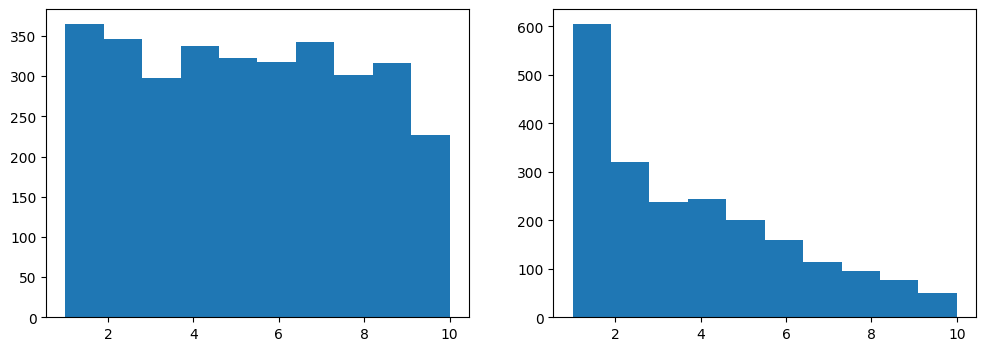

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(df[df['race'] == 'African-American']['decile_score'],bins=10);
ax2.hist(df[df['race'] == 'Caucasian']['decile_score'],bins=10);

In [31]:
pd.crosstab(df['decile_score'],df['race'])

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.

In [32]:
df['c_charge_degree'].value_counts()

c_charge_degree
F    3970
M    2202
Name: count, dtype: int64

In [34]:
#combining medium and high scores and setting them to HighScore and low scores become LowScore
df['score_text_low/high'] = df['score_text'].apply(lambda x : 'HighScore' if x != 'Low' else 'LowScore')

#creating dummy variables for our logistic regression
dummy_df = pd.get_dummies(df[['c_charge_degree','age_cat','race','sex','score_text_low/high']], dtype='int')

#dropping columns which will contain duplicate dummy variables
dummy_df = dummy_df.drop(['age_cat_25 - 45', 'race_Caucasian','sex_Male','score_text_low/high_LowScore','c_charge_degree_F'], axis=1)
df = pd.concat([df, dummy_df], axis=1)

In [35]:
#renaming columns so they don't contain /, -, or spaces
rename_dict = {
    'score_text_low/high_HighScore': 'score_text_low_high_HighScore',
    'age_cat_Less than 25': 'age_cat_Less_than_25',
    'age_cat_Greater than 45': 'age_cat_Greater_than_45',
    'race_African-American': 'race_African_American',
    'race_Native American': 'race_Native_American'
}
df.rename(columns=rename_dict, inplace=True)


In [36]:
import statsmodels.formula.api as smf
model = smf.logit(formula='score_text_low_high_HighScore ~ sex_Female + age_cat_Less_than_25 + age_cat_Greater_than_45 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + priors_count + c_charge_degree_M + two_year_recid', data=df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.499708
         Iterations 6
                                 Logit Regression Results                                
Dep. Variable:     score_text_low_high_HighScore   No. Observations:                 6172
Model:                                     Logit   Df Residuals:                     6160
Method:                                      MLE   Df Model:                           11
Date:                           Fri, 15 Dec 2023   Pseudo R-squ.:                  0.2729
Time:                                   11:59:45   Log-Likelihood:                -3084.2
converged:                                  True   LL-Null:                       -4241.7
Covariance Type:                       nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------

Black defendants are 45% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.

In [37]:
"""%%R
control <- exp(-1.52554) / (1 + exp(-1.52554))
exp(0.47721) / (1 - control + (control * exp(0.47721))) #this equals 1.45 (AKA 45% more likely)

#trying to understand this! 
# odds of a high score assuming everything is controlled / 1 + odds of high assuming controlled 
# => this is the general probability of a high score assuming everything is controlled
#odds / probability of false + (probability true * odds)
# => this somehow calculates an adjusted probability ratio of the increased likelihood of high for black people
# we don't understand how this results in that?""";


In [38]:
#converting log-odds to odds - we can find the odds of a high score assuming everything is controlled
log_odds_intercept = model.params[0]
odds_controlled = np.exp(log_odds_intercept)
p_controlled = odds_controlled / (1 + odds_controlled)
print('Probability of a high score assuming baseline factors: ' + str(p_controlled))
log_odds_african_american = model.params[4]
odds_african_american = np.exp(log_odds_african_american)
adjusted_odds_ratio = odds_african_american / (1 - p_controlled + (p_controlled * odds_african_american))
print('The adjusted odds ratio (the increased likelihood of an African American individual to be given a high score, \nassuming every other factor is controlled is ' + str(adjusted_odds_ratio))
#still don't 100% understand this
#the part i do get is that p_controlled represents the probability at baseline (reference level) for every parameter

#the adjusted odds ratio (correct terminology?) represents the increased likelihood of a high score when not at reference level
#where every other parameter is controlled 

Probability of a high score assuming baseline factors: 0.17864742702528585
The adjusted odds ratio (the increased likelihood of an African American individual to be given a high score, 
assuming every other factor is controlled is 1.4528374133823443


/var/folders/9c/z6lddvh579n5yy9tlh8lzsg00000gn/T/ipykernel_92118/2339394663.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_odds_intercept = model.params[0]
/var/folders/9c/z6lddvh579n5yy9tlh8lzsg00000gn/T/ipykernel_92118/2339394663.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  log_odds_african_american = model.params[4]


Women are 19.4% more likely than men to get a higher score.

Most surprisingly, people under 25 are 2.5 times as likely to get a higher score as middle aged defendants.

### Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score. As before, we can use a logistic regression to test for racial bias.

In [42]:
violent_data = pd.read_csv('CompasAnalysis/compas-scores-two-years-violent.csv')

In [44]:
violent_df = violent_data[['age','c_charge_degree', 'race', 'age_cat', 'v_score_text', 'sex', 'priors_count','days_b_screening_arrest', 'v_decile_score', 'is_recid', 'two_year_recid']]
violent_df = violent_df[violent_df['days_b_screening_arrest'] <= 30]
violent_df = violent_df[violent_df['days_b_screening_arrest'] >= -30]
violent_df = violent_df[violent_df['is_recid'] != -1]
violent_df = violent_df[violent_df['c_charge_degree'] != '0']
violent_df = violent_df[violent_df['v_score_text'] != 'N/A']
assert len(violent_df) == 4020

In [46]:
print(violent_df['age_cat'].value_counts())

age_cat
25 - 45            2300
Greater than 45     954
Less than 25        766
Name: count, dtype: int64


In [48]:
print(violent_df['race'].value_counts())

race
African-American    1918
Caucasian           1459
Hispanic             355
Other                255
Asian                 26
Native American        7
Name: count, dtype: int64


In [50]:
print(violent_df['v_score_text'].value_counts())

v_score_text
Low       2913
Medium     828
High       279
Name: count, dtype: int64


In [52]:
(violent_df['two_year_recid'] == 1).sum()/len(violent_df) * 100

16.218905472636816

In [54]:
(violent_df['two_year_recid'] == 1).sum()

652

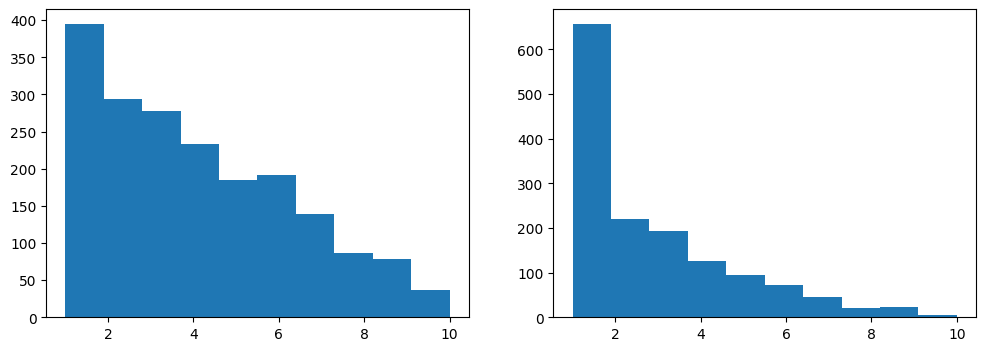

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.hist(violent_df[violent_df['race'] == 'African-American']['v_decile_score'],bins=10);
ax2.hist(violent_df[violent_df['race'] == 'Caucasian']['v_decile_score'],bins=10);

In [58]:
#combining medium and high scores and setting them to HighScore and low scores become LowScore
violent_df['v_score_text_low/high'] = violent_df['v_score_text'].apply(lambda x : 'HighScore' if x != 'Low' else 'LowScore')

#creating dummy variables for our logistic regression
dummy_df = pd.get_dummies(violent_df[['c_charge_degree','age_cat','race','sex','v_score_text_low/high']], dtype='int')

#dropping columns which will contain duplicate dummy variables
dummy_df = dummy_df.drop(['age_cat_25 - 45', 'race_Caucasian','sex_Male','v_score_text_low/high_LowScore','c_charge_degree_F'], axis=1)
violent_df = pd.concat([violent_df, dummy_df], axis=1)

In [59]:
#renaming columns so they don't contain /, -, or spaces
rename_dict = {
    'v_score_text_low/high_HighScore': 'v_score_text_low_high_HighScore',
    'age_cat_Less than 25': 'age_cat_Less_than_25',
    'age_cat_Greater than 45': 'age_cat_Greater_than_45',
    'race_African-American': 'race_African_American',
    'race_Native American': 'race_Native_American'
}
violent_df.rename(columns=rename_dict, inplace=True)


In [60]:
import statsmodels.formula.api as smf
model = smf.logit(formula='v_score_text_low_high_HighScore ~ sex_Female + age_cat_Less_than_25 + age_cat_Greater_than_45 + race_African_American + race_Asian + race_Hispanic + race_Native_American + race_Other + priors_count + c_charge_degree_M + two_year_recid', data=violent_df).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.372983
         Iterations 7
                                  Logit Regression Results                                 
Dep. Variable:     v_score_text_low_high_HighScore   No. Observations:                 4020
Model:                                       Logit   Df Residuals:                     4008
Method:                                        MLE   Df Model:                           11
Date:                             Fri, 15 Dec 2023   Pseudo R-squ.:                  0.3662
Time:                                     11:59:46   Log-Likelihood:                -1499.4
converged:                                    True   LL-Null:                       -2365.9
Covariance Type:                         nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

The violent score overpredicts recidivism for black defendants by 77.3% compared to white defendants.

Defendands under 25 are 7.4 times as likely to get a higher score as middle aged defendants.

## Predictive Accuracy of COMPAS

In order to test whether Compas scores do an accurate job of deciding whether an offender is Low, Medium or High risk,  we ran a Cox Proportional Hazards model. Northpointe, the company that created COMPAS and markets it to Law Enforcement, also ran a Cox model in their [validation study](http://cjb.sagepub.com/content/36/1/21.abstract).

We used the counting model and removed people when they were incarcerated. Due to errors in the underlying jail data, we need to filter out 32 rows that have an end date more than the start date. Considering that there are 13,334 total rows in the data, such a small amount of errors will not affect the results.

In [64]:
cox_df = pd.read_csv('CompasAnalysis/cox-parsed.csv')
cox_df = cox_df[cox_df['score_text'] != 'N/A']
cox_df = cox_df[cox_df['end'] > cox_df['start']]
dummies_df = pd.get_dummies(cox_df[['race','score_text']], dtype='int')
dummies_df = dummies_df.drop(['race_Caucasian','score_text_Low'], axis=1)
cox_df = pd.concat([cox_df, dummies_df], axis=1)
grp = cox_df.drop_duplicates(subset=['id'], keep = 'first')
grp = grp[~grp['score_text'].isna()]
len(grp)

10314

In [66]:
grp['score_text'].value_counts()

score_text
Low       5751
Medium    2611
High      1952
Name: count, dtype: int64

In [68]:
grp['race'].value_counts()

race
African-American    5147
Caucasian           3569
Hispanic             944
Other                571
Asian                 51
Native American       32
Name: count, dtype: int64

In [ ]:
#%%R
#f <- Surv(start, end, event, type="counting") ~ score_factor
#model <- coxph(f, data=data)
#summary(model)

In [222]:
len(grp[grp['score_text']=='Low'])

5751

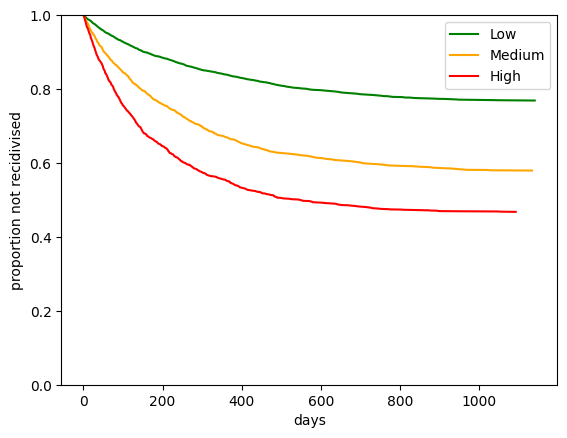

In [229]:
#x = np.arange(0,1141)
#y = np.full(1141,len(grp))
#pd.DataFrame(x,y)
(grp[(grp['is_recid']==1) & (grp['score_text'] == 'Low')]['duration']
 .value_counts()
 .sort_index()
 .cumsum()
 .apply(lambda x: (len(grp[grp['score_text']=='Low']) - x)/len(grp[grp['score_text']=='Low'])).plot(color='green',label='Low'))
(grp[(grp['is_recid']==1) & (grp['score_text'] == 'Medium')]['duration']
 .value_counts()
 .sort_index()
 .cumsum()
 .apply(lambda x: (len(grp[grp['score_text']=='Medium']) - x)/len(grp[grp['score_text']=='Medium'])).plot(color='orange',label='Medium'))
(grp[(grp['is_recid']==1) & (grp['score_text'] == 'High')]['duration']
 .value_counts()
 .sort_index()
 .cumsum()
 .apply(lambda x: (len(grp[grp['score_text']=='High']) - x)/len(grp[grp['score_text']=='High'])).plot(color='red',label='High'))
plt.ylim([0,1])
plt.ylabel('proportion not recidivised')
plt.xlabel('days')
plt.legend();


In [176]:
recid_by_decile = grp.groupby('decile_score.1')['is_recid'].agg(['sum','size'])
recid_by_decile['percent'] = recid_by_decile['sum']/recid_by_decile['size']
recid_by_decile

,sum,size,percent
decile_score.1,,,
1,333,2206,0.150952
2,325,1384,0.234827
3,312,1094,0.285192
4,359,1067,0.336457
5,348,922,0.377440
6,378,881,0.429058
7,372,808,0.460396
8,370,712,0.519663
9,367,706,0.519830


In [179]:
recid_by_size = grp.groupby('score_text')['is_recid'].agg(['sum','size'])
recid_by_size.loc['HighMedium'] = recid_by_size.loc['High'] + recid_by_size.loc['Medium']
recid_by_size['percent'] = recid_by_size['sum']/recid_by_size['size']
display(recid_by_size.loc['HighMedium','percent']/recid_by_size.loc['Low','percent'],recid_by_size.loc['High','percent']/recid_by_size.loc['Low','percent'])

2.0266205404250206

2.3033191633053325

0.6854095976732913


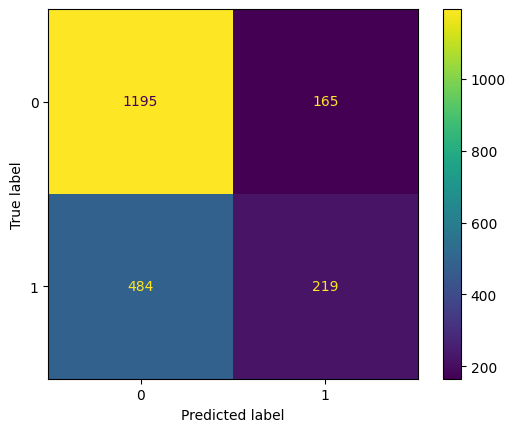

In [177]:
X = pd.get_dummies(grp['score_text'])
y = grp['is_recid']
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
model = LogisticRegression()
model.fit(x_train, y_train)
accuracy = (model.predict(x_test) == y_test).sum()/len(y_test)
print(accuracy)
ConfusionMatrixDisplay(confusion_matrix(y_test,model.predict(x_test))).plot();

People placed in the High category are 3.5 times as likely to recidivate, and the COMPAS system's concordance 63.6%. This is lower than the accuracy quoted in the Northpoint study of 68%.

In [ ]:
%%R
decile_f <- Surv(start, end, event, type="counting") ~ decile_score
dmodel <- coxph(decile_f, data=data)
summary(dmodel)

0.6728065923412506


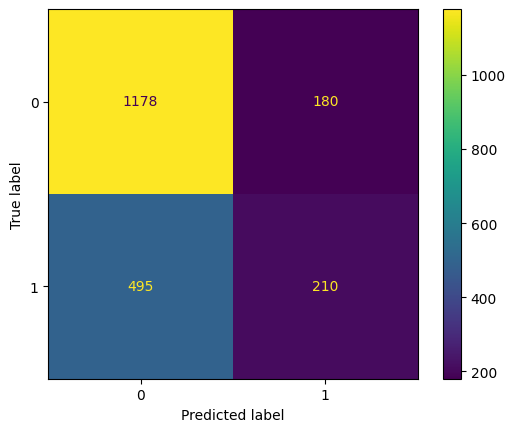

In [178]:
X = pd.get_dummies(grp['decile_score.1'])
y = grp['is_recid']
x_train, x_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
model = LogisticRegression()
model.fit(x_train, y_train)
accuracy = (model.predict(x_test) == y_test).sum()/len(y_test)
print(accuracy)
ConfusionMatrixDisplay(confusion_matrix(y_test,model.predict(x_test))).plot();

In [168]:
model.predict(x_test).sum()

0

COMPAS's decile scores are a bit more accurate at 66%.

We can test if the algorithm is behaving differently across races by including a race interaction term in the cox model.

In [ ]:
%%R
f2 <- Surv(start, end, event, type="counting") ~ race_factor + score_factor + race_factor * score_factor
model <- coxph(f2, data=data)
print(summary(model))

The interaction term shows a similar disparity as the logistic regression above.

High risk white defendants are 3.61 more likely than low risk white defendants, while High risk black defendants are 2.99 more likely than low.

In [ ]:
import math
print("Black High Hazard: %.2f" % (math.exp(-0.18976 + 1.28350)))
print("White High Hazard: %.2f" % (math.exp(1.28350)))
print("Black Medium Hazard: %.2f" % (math.exp(0.84286-0.17261)))
print("White Medium Hazard: %.2f" % (math.exp(0.84286)))

In [ ]:
%%R -w 900 -h 563 -u px

fit <- survfit(f, data=data)

plotty <- function(fit, title) {
  return(autoplot(fit, conf.int=T, censor=F) + ggtitle(title) + ylim(0,1))
}
plotty(fit, "Overall")

Black defendants do recidivate at higher rates according to race specific Kaplan Meier plots.

In [ ]:
%%R -w 900 -h 363 -u px
white <- filter(data, race == "Caucasian")
white_fit <- survfit(f, data=white)

black <- filter(data, race == "African-American")
black_fit <- survfit(f, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

In [ ]:
%%R
summary(fit, times=c(730))

In [ ]:
%%R
summary(black_fit, times=c(730))

In [ ]:
%%R
summary(white_fit, times=c(730))

Race specific models have similar concordance values.

In [ ]:
%%R
summary(coxph(f, data=white))

In [ ]:
%%R
summary(coxph(f, data=black))

Compas's violent recidivism score has a slightly higher overall concordance score of 65.1%.

In [ ]:
%%R
violent_data <- filter(filter(read.csv("./cox-violent-parsed.csv"), score_text != "N/A"), end > start) %>%
        mutate(race_factor = factor(race,
                                  labels = c("African-American", 
                                             "Asian",
                                             "Caucasian", 
                                             "Hispanic", 
                                             "Native American",
                                             "Other"))) %>%
        within(race_factor <- relevel(race_factor, ref = 3)) %>%
        mutate(score_factor = factor(score_text)) %>%
        within(score_factor <- relevel(score_factor, ref=2))


vf <- Surv(start, end, event, type="counting") ~ score_factor
vmodel <- coxph(vf, data=violent_data)
vgrp <- violent_data[!duplicated(violent_data$id),]
print(nrow(vgrp))
summary(vmodel)

In this case, there isn't a significant coefficient on African American's with High Scores.

In [ ]:
%%R
vf2 <- Surv(start, end, event, type="counting") ~ race_factor + race_factor * score_factor
vmodel <- coxph(vf2, data=violent_data)
summary(vmodel)

In [ ]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "African-American")))

In [ ]:
%%R
summary(coxph(vf, data=filter(violent_data, race == "Caucasian")))

In [ ]:
%%R -w 900 -h 363 -u px
white <- filter(violent_data, race == "Caucasian")
white_fit <- survfit(vf, data=white)

black <- filter(violent_data, race == "African-American")
black_fit <- survfit(vf, data=black)

grid.arrange(plotty(white_fit, "White defendants"), 
             plotty(black_fit, "Black defendants"), ncol=2)

## Directions of the Racial Bias

The above analysis shows that the Compas algorithm does overpredict African-American defendant's future recidivism, but we haven't yet explored the direction of the bias. We can discover fine differences in overprediction and underprediction by comparing Compas scores across racial lines.

In [ ]:
from truth_tables import PeekyReader, Person, table, is_race, count, vtable, hightable, vhightable
from csv import DictReader

people = []
with open("./cox-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                people.append(p)
    except StopIteration:
        pass

pop = list(filter(lambda i: ((i.recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.score_valid, people))))
recid = list(filter(lambda i: i.recidivist == True and i.lifetime <= 730, pop))
rset = set(recid)
surv = [i for i in pop if i not in rset]

In [ ]:
print("All defendants")
table(list(recid), list(surv))

In [ ]:
print("Total pop: %i" % (2681 + 1282 + 1216 + 2035))

In [ ]:
import statistics
print("Average followup time %.2f (sd %.2f)" % (statistics.mean(map(lambda i: i.lifetime, pop)),
                                                statistics.stdev(map(lambda i: i.lifetime, pop))))
print("Median followup time %i" % (statistics.median(map(lambda i: i.lifetime, pop))))

Overall, the false positive rate is 32.35%.

In [ ]:
print("Black defendants")
is_afam = is_race("African-American")
table(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

That number is higher for African Americans at 44.85%.

In [ ]:
print("White defendants")
is_white = is_race("Caucasian")
table(list(filter(is_white, recid)), list(filter(is_white, surv)))

And lower for whites at 23.45%.

In [ ]:
44.85 / 23.45

Which means under COMPAS black defendants are 91% more likely to get a higher score and not go on to commit more crimes than white defendants after two year.

COMPAS scores misclassify white reoffenders as low risk at 70.4% more often than black reoffenders.

In [ ]:
47.72 / 27.99

In [ ]:
hightable(list(filter(is_white, recid)), list(filter(is_white, surv)))

In [ ]:
hightable(list(filter(is_afam, recid)), list(filter(is_afam, surv)))

## Risk of Violent Recidivism

Compas also offers a score that aims to measure a persons risk of violent recidivism, which has a similar overall accuracy to the Recidivism score.

In [ ]:
vpeople = []
with open("./cox-violent-parsed.csv") as f:
    reader = PeekyReader(DictReader(f))
    try:
        while True:
            p = Person(reader)
            if p.valid:
                vpeople.append(p)
    except StopIteration:
        pass

vpop = list(filter(lambda i: ((i.violent_recidivist == True and i.lifetime <= 730) or
                              i.lifetime > 730), list(filter(lambda x: x.vscore_valid, vpeople))))
vrecid = list(filter(lambda i: i.violent_recidivist == True and i.lifetime <= 730, vpeople))
vrset = set(vrecid)
vsurv = [i for i in vpop if i not in vrset]

In [ ]:
print("All defendants")
vtable(list(vrecid), list(vsurv))

Even moreso for Black defendants.

In [ ]:
print("Black defendants")
is_afam = is_race("African-American")
vtable(list(filter(is_afam, vrecid)), list(filter(is_afam, vsurv)))

In [ ]:
print("White defendants")
is_white = is_race("Caucasian")
vtable(list(filter(is_white, vrecid)), list(filter(is_white, vsurv)))

Black defendants are twice as likely to be false positives for a Higher violent score than white defendants.

In [ ]:
38.14 / 18.46

White defendants are 63% more likely to get a lower score and commit another crime than Black defendants.

In [ ]:
62.62 / 38.37

## Gender differences in Compas scores

In terms of underlying recidivism rates, we can look at gender specific Kaplan Meier estimates. There is a striking difference between women and men.

In [ ]:
%%R

female <- filter(data, sex == "Female")
male   <- filter(data, sex == "Male")
male_fit <- survfit(f, data=male)
female_fit <- survfit(f, data=female)

In [ ]:
%%R
summary(male_fit, times=c(730))

In [ ]:
%%R
summary(female_fit, times=c(730))

In [ ]:
%%R -w 900 -h 363 -u px
grid.arrange(plotty(female_fit, "Female"), plotty(male_fit, "Male"),ncol=2)

As these plots show, the Compas score treats a High risk women the same as a Medium risk man.

<Axes: >

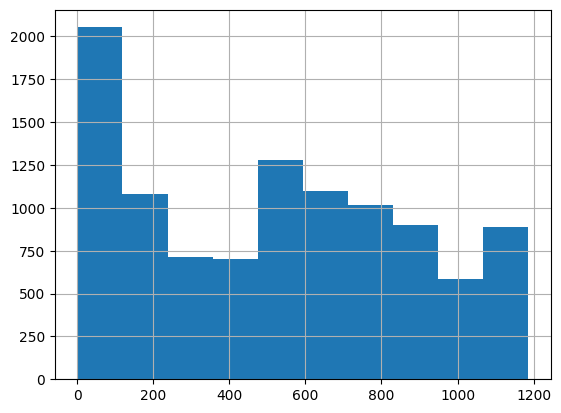

In [187]:
grp['duration'].hist()

In [192]:
grp[['is_recid','start','end','duration']].head(50)

,is_recid,start,end,duration
0,0,0,327,327
2,1,9,159,150
3,1,0,63,63
5,0,0,1174,1174
6,0,0,1102,1102
7,0,1,853,852
8,1,5,40,35
9,0,0,265,265
12,0,2,747,745
13,0,32,240,208
